## Setup

### Imports

In [1]:
import sys; sys.path.append('..')

In [2]:
# ! pip install lovely-tensors

In [3]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformer_lens import HookedTransformer, HookedTransformerConfig

In [23]:
! wget https://raw.githubusercontent.com/pytorch/pytorch/main/torch/utils/collect_env.py
! python collect_env.py
# For security purposes, please check the contents of collect_env.py before running it.

--2024-04-11 12:47:59--  https://raw.githubusercontent.com/pytorch/pytorch/main/torch/utils/collect_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22068 (22K) [text/plain]
Saving to: ‘collect_env.py’

collect_env.py      100%[===================>]  21.55K  --.-KB/s    in 0.001s  

2024-04-11 12:47:59 (18.2 MB/s) - ‘collect_env.py’ saved [22068/22068]

PyTorch version: 2.0.1
Is debug build: False
CUDA used to build PyTorch: None
ROCM used to build PyTorch: N/A

OS: macOS 14.4.1 (arm64)
GCC version: Could not collect
Clang version: 15.0.0 (clang-1500.3.9.4)
CMake version: Could not collect
Libc version: N/A

Python version: 3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ] (64-bit runtime)
Python platform: macOS-14.4.1-arm64-arm-64bi

In [20]:
import torch

M = torch.zeros(3,3, device='cpu')

M[1,1] = torch.tensor([3.], device='mps')
M[-1,-1] = torch.tensor([-3.], device='mps')
M[0,1] = torch.tensor([32.], device='mps')

M

tensor([[32.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])

In [24]:
import torch

M = torch.zeros(3,3, device='mps')

M[1,1] = torch.tensor([3.], device='mps')
M[-1,-1] = torch.tensor([-3.], device='mps')
M[0,1] = torch.tensor([32.], device='mps')

print(M)

tensor([[ 0., 32.,  0.],
        [ 0.,  3.,  0.],
        [ 0.,  0., -3.]], device='mps:0')


In [5]:
import wandb
from tqdm.auto import tqdm

from omegaconf import OmegaConf

from datetime import datetime

from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from src.tree import list2tree
from src.tree_dataset import TreeDataset, parse_input_idx, input_tokens_to_tree, tree_to_edges
from src.utils import seed_all


from src.trainer import TreeTrainer

In [7]:
def load_model(device):
    n_states = 16
    max_seq_length = n_states * 4 + 2
    
    number_tokens = sorted([str(i) for i in range(n_states)], key=lambda x: len(x), reverse=True)
    idx2tokens = [",", ":", "|"] + [f">{t}" for t in number_tokens] + number_tokens
    tokens2idx = {token: idx for idx, token in enumerate(idx2tokens)}
    
    
    cfg = HookedTransformerConfig(
        n_layers=6,
        d_model=128,
        n_ctx=max_seq_length - 1,
        n_heads=1,
        d_mlp=512,
        d_head=128,
        #attn_only=True,
        d_vocab=len(idx2tokens),
        device=device,
        attention_dir= "causal",
        act_fn="gelu",
    )
    model = HookedTransformer(cfg)
    
    model.load_state_dict(torch.load("/Users/mykhailokilianovskyi/src/backward-chaining-circuits/model.pt", map_location=torch.device(device)))
    
    return model

(q_out @ k_out.T)=tensor([[14.9069]], grad_fn=<MmBackward0>), scores[q, k]=tensor(14.9069, grad_fn=<SelectBackward0>) k=0 q=1
(q_out @ k_out.T)=tensor([[-3.8319]], grad_fn=<MmBackward0>), scores[q, k]=tensor(-3.8319, grad_fn=<SelectBackward0>) k=0 q=2
(q_out @ k_out.T)=tensor([[-1.1249]], grad_fn=<MmBackward0>), scores[q, k]=tensor(-1.1249, grad_fn=<SelectBackward0>) k=1 q=2
(q_out @ k_out.T)=tensor([[-12.4313]], grad_fn=<MmBackward0>), scores[q, k]=tensor(-12.4313, grad_fn=<SelectBackward0>) k=0 q=3
(q_out @ k_out.T)=tensor([[1.2763]], grad_fn=<MmBackward0>), scores[q, k]=tensor(1.2763, grad_fn=<SelectBackward0>) k=1 q=3
(q_out @ k_out.T)=tensor([[18.0575]], grad_fn=<MmBackward0>), scores[q, k]=tensor(18.0575, grad_fn=<SelectBackward0>) k=2 q=3


Text(0.5, 0, 'Position Embedding in Key')

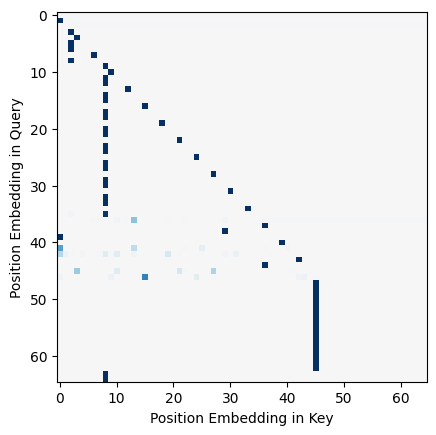

In [8]:
model = load_model('cpu')
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T

            if q < 4:
                print(f'{(q_out @ k_out.T)=}, {scores[q, k]=} {k=} {q=}')


plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

(q_out @ k_out.T)=tensor([[14.9069]], device='mps:0', grad_fn=<MmBackward0>), scores[q, k]=tensor(0., grad_fn=<SelectBackward0>) k=0 q=1
(q_out @ k_out.T)=tensor([[-3.8319]], device='mps:0', grad_fn=<MmBackward0>), scores[q, k]=tensor(0., grad_fn=<SelectBackward0>) k=0 q=2
(q_out @ k_out.T)=tensor([[-1.1249]], device='mps:0', grad_fn=<MmBackward0>), scores[q, k]=tensor(0., grad_fn=<SelectBackward0>) k=1 q=2
(q_out @ k_out.T)=tensor([[-12.4314]], device='mps:0', grad_fn=<MmBackward0>), scores[q, k]=tensor(0., grad_fn=<SelectBackward0>) k=0 q=3
(q_out @ k_out.T)=tensor([[1.2763]], device='mps:0', grad_fn=<MmBackward0>), scores[q, k]=tensor(0., grad_fn=<SelectBackward0>) k=1 q=3
(q_out @ k_out.T)=tensor([[18.0575]], device='mps:0', grad_fn=<MmBackward0>), scores[q, k]=tensor(0., grad_fn=<SelectBackward0>) k=2 q=3


Text(0.5, 0, 'Position Embedding in Key')

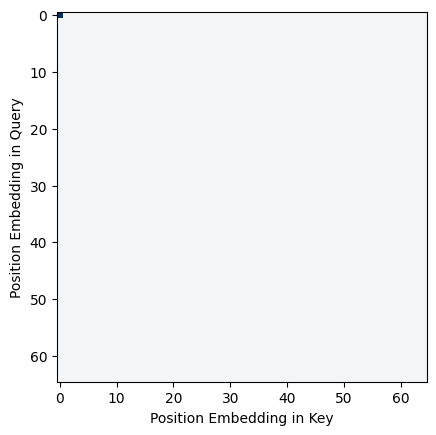

In [9]:
model = load_model('mps')
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T

            if q < 4:
                print(f'{(q_out @ k_out.T)=}, {scores[q, k]=} {k=} {q=}')


plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

In [10]:
scores = scores.detach().cpu().clone()
scores_np_mps0 = scores.detach().detach().clone().cpu().numpy()

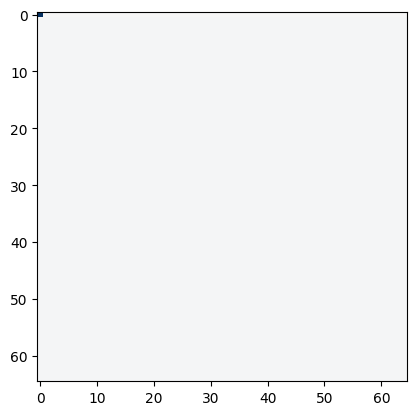

In [11]:
plt.imshow(scores.softmax(dim=1).detach().numpy(), cmap="RdBu", vmin=-1, vmax=1)

Text(0.5, 0, 'Position Embedding in Key')

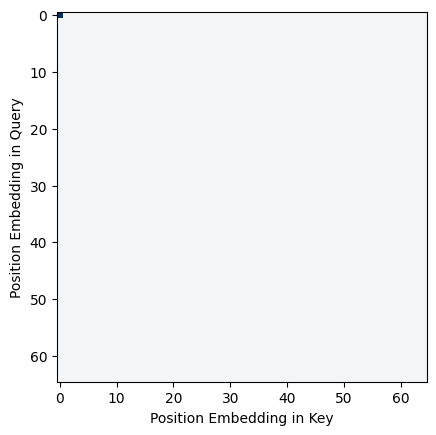

In [12]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T

scores = scores.detach().cpu().clone()
scores_np_mps0 = scores.detach().detach().clone().cpu().numpy()
plt.imshow(scores.softmax(dim=1).detach().numpy(), cmap="RdBu", vmin=-1, vmax=1)
scores_np_mps1 = scores.detach().detach().cpu().numpy()

plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

In [13]:
scores

tensor([[13.9015,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [14]:
scores_np_mps1

array([[13.901515,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [15]:
model.blocks[0].attn.W_Q[0].v

AttributeError: 'Tensor' object has no attribute 'v'

In [ ]:
scores.softmax(dim=1).detach()[:3, :3].v